In [4]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
!pip install langdetect
from langdetect import detect



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## EDA

In [6]:
netflix_reviews_df = pd.read_csv('netflix_reviews (1).csv')
netflix_reviews_df.drop(columns = ['reviewId','userName','reviewCreatedVersion','at','appVersion'],inplace = True)
netflix_reviews_df.head()

,content,score,thumbsUpCount
0,This AAP I very nice 😍🤩😊☺️🥰🤩🤩,5,0
1,very good,5,0
2,I love it🥹🥹,5,0
3,"It's annoying, i cant watch. it keeps on sayin...",2,0
4,this app is good u can all kinds of movies,5,0


# <h3>Data Processing</h3>

In [7]:
!pip install emoji
import emoji

def de_emojize_text(text):
    for x in text: # If a text contains an emoji, convert that emoji into its english name
        if emoji.is_emoji(x):
            demojized = emoji.demojize(x).split("_")
            demojized_string = " ".join(demojized)
            text = text.replace(x, demojized_string)
    return text

In [8]:
def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    return text

# Apply Function
netflix_reviews_df['cleaned_content'] = netflix_reviews_df['content'].astype(str).apply(de_emojize_text).apply(preprocess_text)


# EDA

In [9]:
netflix_reviews_df.head()

,content,score,thumbsUpCount,cleaned_content
0,This AAP I very nice 😍🤩😊☺️🥰🤩🤩,5,0,this aap i very nice smiling face with heartey...
1,very good,5,0,very good
2,I love it🥹🥹,5,0,i love itface holding back tearsface holding b...
3,"It's annoying, i cant watch. it keeps on sayin...",2,0,its annoying i cant watch it keeps on saying l...
4,this app is good u can all kinds of movies,5,0,this app is good u can all kinds of movies


In [10]:
print("Null rows:\n", netflix_reviews_df[['content','score','thumbsUpCount']].isnull().sum(), "\n")
dups = netflix_reviews_df.duplicated(subset=['cleaned_content']).sum()
print(f"Duplicate reviews: {dups}")

Null rows:
 content          6
score            0
thumbsUpCount    0
dtype: int64 

Duplicate reviews: 6806


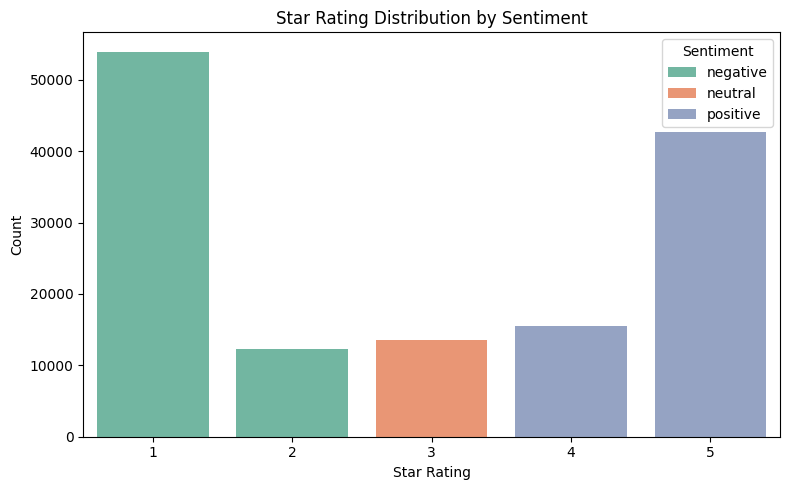

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(x='score', hue='sentiment', data=netflix_reviews_df, palette='Set2')
plt.title('Star Rating Distribution by Sentiment')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [14]:
def get_top_n(corpus, ngram_range=(1,1), n=50):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(corpus)
    freqs = zip(vec.get_feature_names_out(), X.sum(axis=0).A1)
    return sorted(freqs, key=lambda x: x[1], reverse=True)[:n]

for ng in [(1,1),(2,2),(3,3)]:
    print(f"\n=== Top 50 {ng[0]}-grams ===")
    for sentiment in ['negative','neutral','positive']:
        corpus = netflix_reviews_df.loc[
            netflix_reviews_df['sentiment']==sentiment, 'cleaned_content'
        ]
        topn = get_top_n(corpus, ngram_range=ng, n=50)
        print(f"\n{sentiment.upper()}:\n", [w for w,c in topn[:10]], "…")



=== Top 50 1-grams ===

NEGATIVE:
 ['netflix', 'app', 'watch', 'just', 'phone', 'movies', 'dont', 'shows', 'im', 'update'] …

NEUTRAL:
 ['app', 'netflix', 'movies', 'watch', 'good', 'like', 'shows', 'just', 'dont', 'im'] …

POSITIVE:
 ['netflix', 'app', 'movies', 'good', 'love', 'watch', 'shows', 'great', 'like', 'best'] …

=== Top 50 2-grams ===

NEGATIVE:
 ['open app', 'doesnt work', 'netflix app', 'dont know', 'watch netflix', 'want watch', 'new update', 'black screen', 'reach netflix', 'wont let'] …

NEUTRAL:
 ['good app', 'love netflix', 'shows movies', 'want watch', 'tv shows', 'great app', 'dont know', 'netflix app', 'movies shows', 'movies series'] …

POSITIVE:
 ['love netflix', 'love app', 'great app', 'shows movies', 'good app', 'tv shows', 'face smiling', 'best app', 'watch movies', 'movies shows'] …

=== Top 50 3-grams ===

NEGATIVE:
 ['reach netflix service', 'faceenraged faceenraged faceenraged', 'sorry reach netflix', 'crying faceloudly crying', 'symbols mouthface symbo

In [15]:
def detect_lang(text):
    try:
        return detect(text)
    except:
        return 'error'
netflix_reviews_df['language'] = (
    netflix_reviews_df['content'].astype(str).apply(detect_lang)
)
print(netflix_reviews_df['language'].value_counts().head(10))
# fraction non-en
non_en = netflix_reviews_df['language'].ne('en').mean()
print(f"Fraction non-English (incl. errors): {non_en:.2%}")


language
en       127813
so         1979
af         1175
ro          657
id          513
error       508
fr          461
it          431
de          399
no          391
Name: count, dtype: int64
Fraction non-English (incl. errors): 7.33%


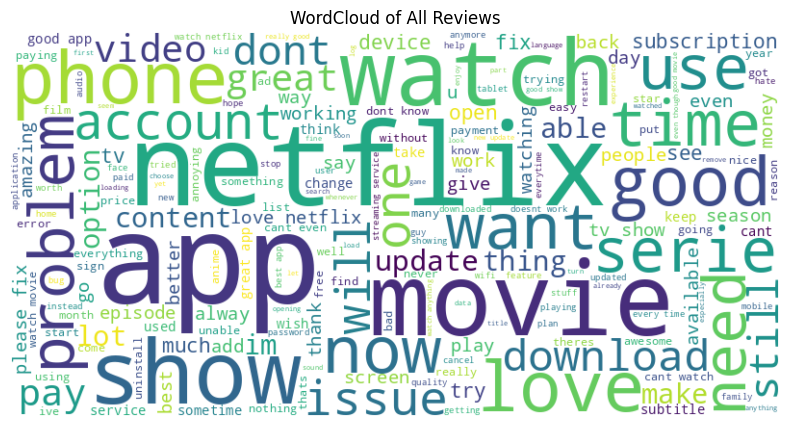

In [16]:
all_text = " ".join(netflix_reviews_df['cleaned_content'])
wc = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=STOPWORDS
).generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of All Reviews")
plt.show()

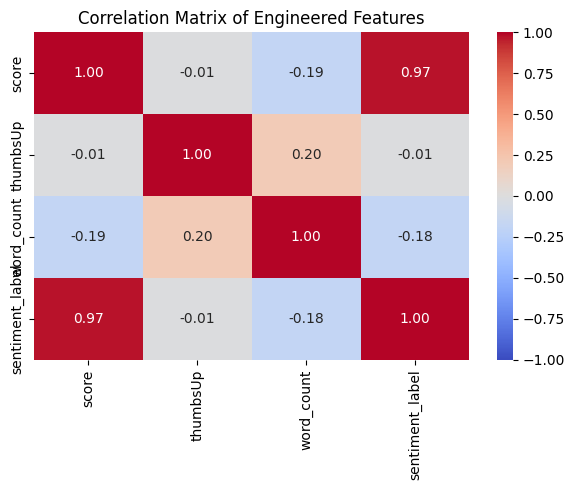

In [21]:
df_corr = pd.DataFrame({
    'score': netflix_reviews_df['score'],
    'thumbsUp': netflix_reviews_df['thumbsUpCount'],
    'word_count': netflix_reviews_df['cleaned_content'].str.split().apply(len),
    'sentiment_label': netflix_reviews_df['sentiment'].map({'negative':0,'neutral':1,'positive':2})
})

plt.figure(figsize=(6,5))
sns.heatmap(
    df_corr.corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1, vmax=1
)
plt.title("Correlation Matrix of Engineered Features")
plt.tight_layout()
plt.show()


# <h3>Feature Extraction</h3>

In [22]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the cleaned text data
X = vectorizer.fit_transform(netflix_reviews_df['cleaned_content'])


<h3>Sentiment Analysis Model</h3>

In [12]:
def score_to_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

# Apply function
netflix_reviews_df['sentiment'] = netflix_reviews_df['score'].apply(score_to_sentiment)

<h3>Tokenize and Pad Sequences</h3>

In [23]:
max_len = 100  # Max number of words in a sequence
max_features = 20000
# Tokenize the text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(netflix_reviews_df['cleaned_content'])
sequences = tokenizer.texts_to_sequences(netflix_reviews_df['cleaned_content'])

# Pad the sequences
X = pad_sequences(sequences, maxlen=max_len)

# Convert sentiments to numerical labels
sentiment_label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y = netflix_reviews_df['sentiment'].map(sentiment_label_map).values

# Split the data into training, testing, valid sets
X_train, X_valid, y_train, y_valid = train_test_split(netflix_reviews_df['content'],
                                                      netflix_reviews_df['sentiment'],
                                                      test_size=0.1,
                                                      random_state=101)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid,
                                                    y_valid,
                                                    test_size=0.5,
                                                    random_state=101)


NameError: name 'history' is not defined

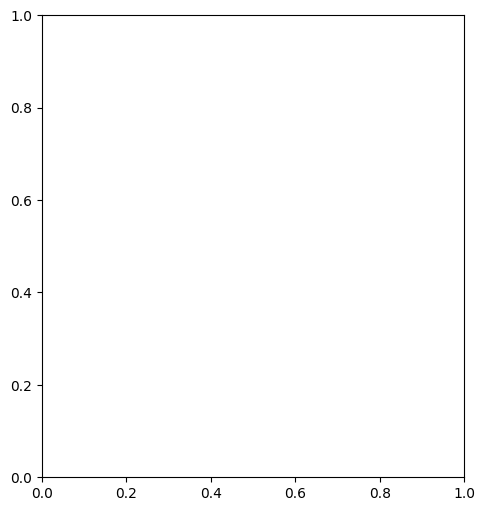

In [24]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [ ]:


sentiment_score_counts = netflix_reviews_df.groupby(['sentiment', 'score']).size().unstack()
sentiment_score_counts.plot(kind='bar', stacked=True)

plt.title('Score by Sentiment ')
plt.xlabel('Sentiment')
plt.ylabel('Number of Score')
plt.legend(title='Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<h3>Sentiment and Score Percentage</h3>

In [ ]:
sentiment_score_counts = netflix_reviews_df.groupby(['sentiment', 'score']).size().unstack()

for sentiment in sentiment_score_counts.index:
    sentiment_counts = sentiment_score_counts.loc[sentiment]
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Score percentage for Sentiment: {sentiment}')
    plt.axis('equal')
    plt.show()
